# Get raw data

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os

USE_ALIGNZERO = 1 

# Define base paths for your recordings
base_paths = [
    "C:/Quick_Disk/tonge_project/data/Recordings_Individual_Classes1",
    "C:/Quick_Disk/tonge_project/data/Recordings_Individual_Classes2",
    "C:/Quick_Disk/tonge_project/data/Recordings_Individual_Classes3"
]

# Class labels
class_labels = ['none', 'left', 'left_front', 'front', 'right_front', 'right', 'swallow']

# Sampling rate (assumed constant)
sampling_rate = 250  # Hz

# Container for all data
all_data = []

# Loop over sessions and classes
for session_id, base_path in enumerate(base_paths, start=1):
    for class_label in class_labels:
        file_path = os.path.join(base_path, f"{class_label}.csv")
        
        try:
            df = pd.read_csv(file_path, sep='\t', skiprows=5, engine='python')
            df.columns = [f"ch_{i}" for i in range(df.shape[1])]  # standardize column names
            
            df["label"] = class_label
            df["session"] = session_id
            
            all_data.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# Combine into a single DataFrame
combined_df = pd.concat(all_data, axis=0).reset_index(drop=True)

# Print basic info
print(f"Combined data shape: {combined_df.shape}")
print("Combined labeled data acquired")

# Optional: view class distribution
print(combined_df['label'].value_counts())

if USE_ALIGNZERO == 1:
    # Identify signal columns (all columns except 'label' and 'session')
    signal_cols = [col for col in combined_df.columns if col not in ['label', 'session']]
    
    # Subtract mean of each signal column to center around zero amplitude
    for col in signal_cols:
        mean_val = combined_df[col].mean()
        combined_df[col] = combined_df[col] - mean_val
    
    print("All signal channels aligned to zero amplitude (mean removed).")



Combined data shape: (877942, 26)
Combined labeled data acquired
label
none           232940
left           192107
left_front     157571
front          119776
right_front     89165
right           58378
swallow         28005
Name: count, dtype: int64
All signal channels aligned to zero amplitude (mean removed).


## Plot raw data & annotations

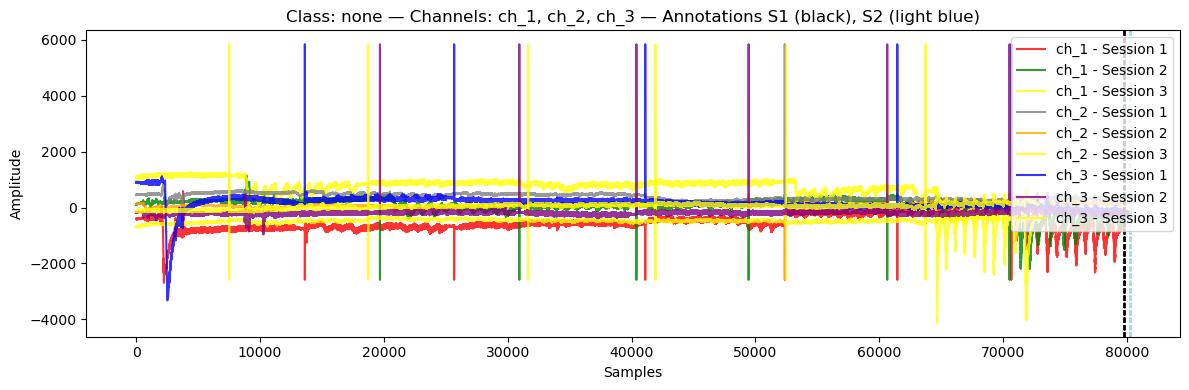

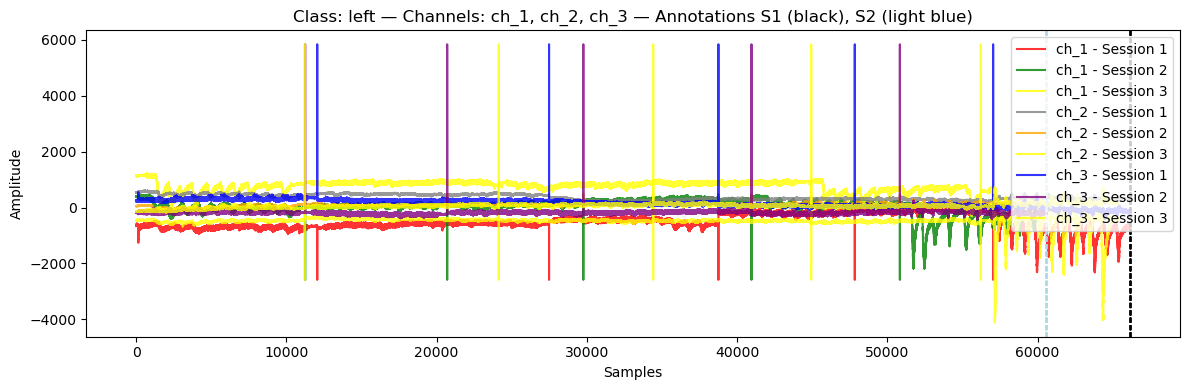

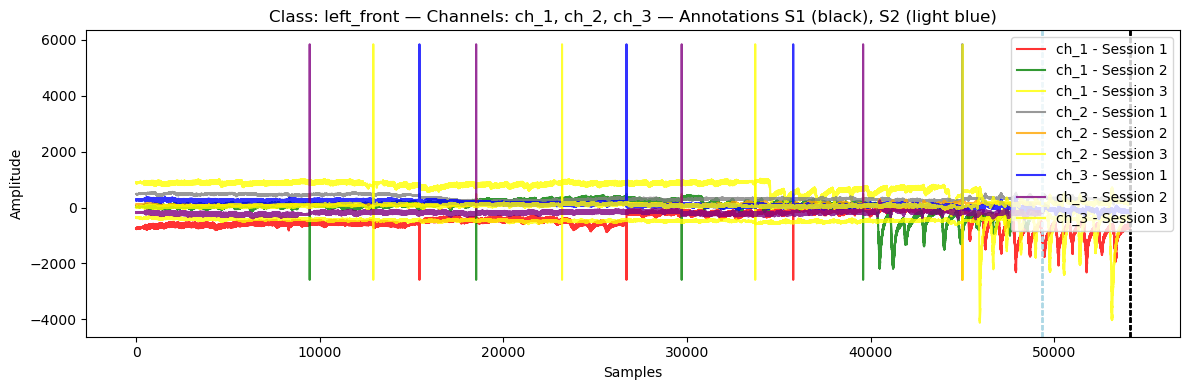

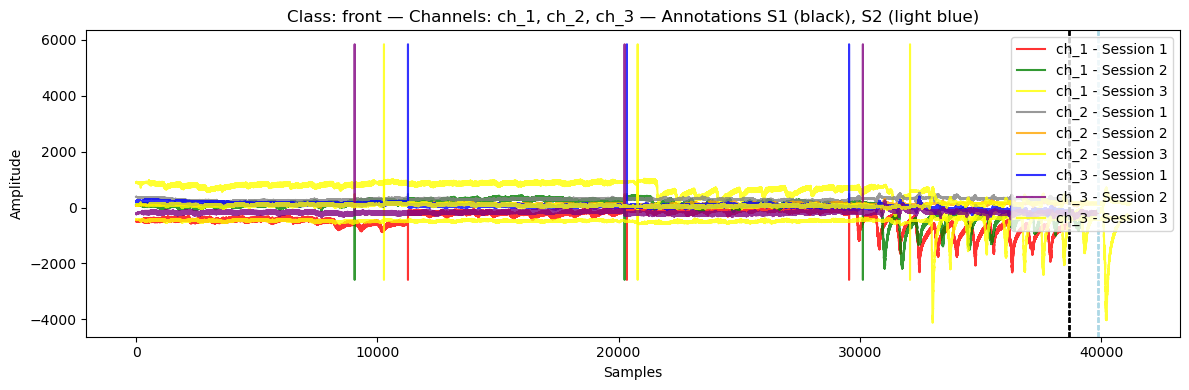

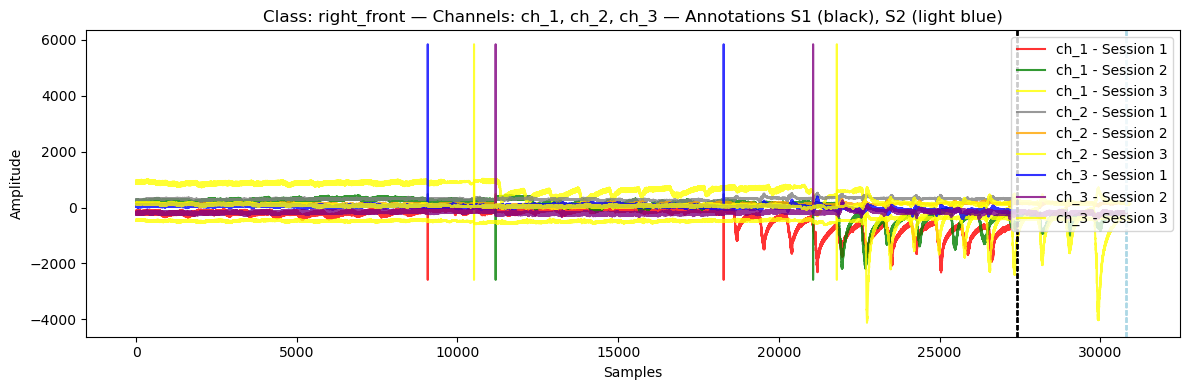

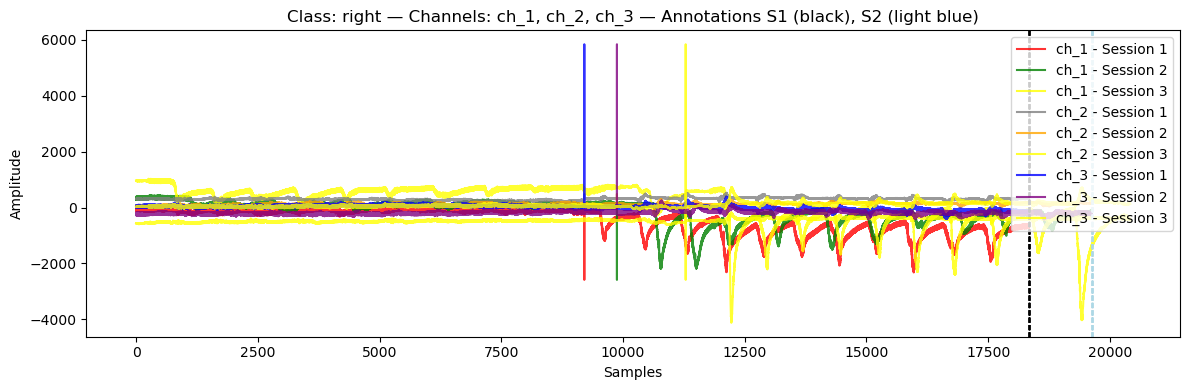

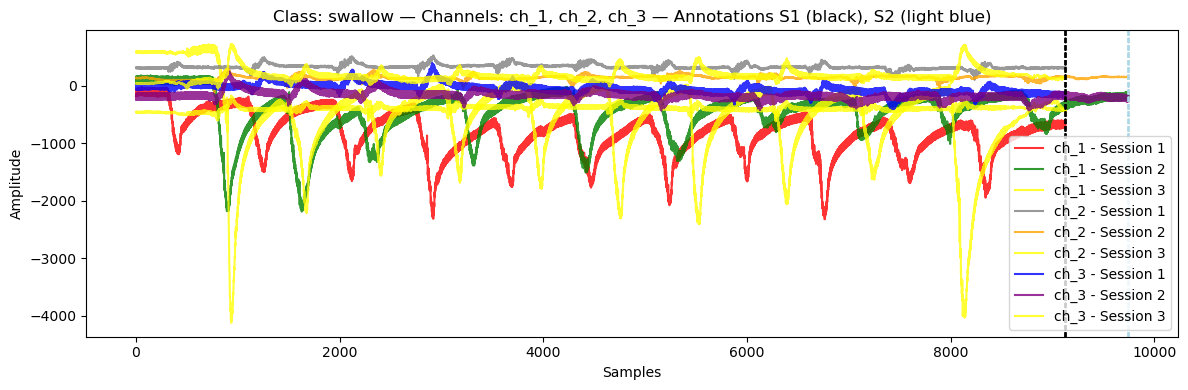

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Define paths
annotation_base_path = "C:/Quick_Disk/tonge_project/scripts/data/annotations"

# Channels to visualize
channels_to_plot = ["ch_1", "ch_2", "ch_3"]
session_colors = {
    1: {"ch_1": "red", "ch_2": "gray", "ch_3": "blue"},
    2: {"ch_1": "green", "ch_2": "orange", "ch_3": "purple"},
    3: {"ch_1": "yellow", "ch_2": "yellow", "ch_3": "yellow"}
}

# Class labels
class_labels = combined_df["label"].unique()

for label in class_labels:
    # --- Filter data ---
    df1 = combined_df[(combined_df["label"] == label) & (combined_df["session"] == 1)].reset_index(drop=True)
    df2 = combined_df[(combined_df["label"] == label) & (combined_df["session"] == 2)].reset_index(drop=True)
    df3 = combined_df[(combined_df["label"] == label) & (combined_df["session"] == 3)].reset_index(drop=True)

    # --- Read annotations for sessions ---
    def get_annotation_indices(df, label, session_num):
        annotation_file = os.path.join(annotation_base_path, f"Individual_annotation{session_num}_{label}.csv")
        if "ch_22" not in df.columns:
            print(f"ch_22 missing in session {session_num} data for class {label}. Skipping annotation.")
            return []
        try:
            annotations = pd.read_csv(annotation_file)
            unix_timestamps = annotations.iloc[:, 1].values
            signal_times = df["ch_22"].values
            return [(np.abs(signal_times - ts)).argmin() for ts in unix_timestamps]
        except Exception as e:
            print(f" Could not process annotations for {label}, session {session_num}: {e}")
            return []

    sample_indices_s1 = get_annotation_indices(df1, label, session_num=1)
    sample_indices_s2 = get_annotation_indices(df2, label, session_num=2)
    sample_indices_s3 = get_annotation_indices(df3, label, session_num=3)

    # --- Plotting ---
    plt.figure(figsize=(12, 4))
    
    for ch in channels_to_plot:
        plt.plot(df1[ch], label=f"{ch} - Session 1", color=session_colors[1][ch], alpha=0.8)
        plt.plot(df2[ch], label=f"{ch} - Session 2", color=session_colors[2][ch], alpha=0.8)
        plt.plot(df3[ch], label=f"{ch} - Session 3", color=session_colors[3][ch], alpha=0.8)

    # Vertical lines for annotations
    for idx in sample_indices_s1:
        plt.axvline(x=idx, color='black', linestyle='--', linewidth=1, label='_nolegend_')
    for idx in sample_indices_s2:
        plt.axvline(x=idx, color='lightblue', linestyle='--', linewidth=1, label='_nolegend_')

    # Plot settings
    plt.title(f"Class: {label} — Channels: ch_1, ch_2, ch_3 — Annotations S1 (black), S2 (light blue)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()



# Create windows

In [26]:
import numpy as np
import os
import pandas as pd  # Ensure pandas is imported

# Define your classes with short labels
windowed_data = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []}
windowed_data_test = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []}

window_size = 250  

# Map your class_labels from original to short ones
class_map = {
    'left': 'l',
    'left_front': 'lf',
    'front': 'f',
    'right_front': 'rf',
    'right': 'r',
    'swallow': 's',
    'none': 'n'
}

def extract_windows_for_class(class_label, session_num):
    df = combined_df[(combined_df['label'] == class_label) & (combined_df['session'] == session_num)].reset_index(drop=True)

    annotation_file = os.path.join(annotation_base_path, f"Individual_annotation{session_num}_{class_label}.csv")
    
    try:
        annotations = pd.read_csv(annotation_file)
    except Exception as e:
        print(f"Could not read annotation file for {class_label}, session {session_num}: {e}")
        return []

    if 'ch_22' not in df.columns:
        print(f"ch_22 missing in session {session_num} data for class {class_label}, skipping.")
        return []

    signal_times = df['ch_22'].values
    windows = []

    for ts in annotations.iloc[:, 1].values:
        if len(signal_times) == 0:
            continue
        start_idx = (np.abs(signal_times - ts)).argmin()
        end_idx = start_idx + window_size

        if end_idx <= len(df):
            window = df.loc[start_idx:end_idx-1, ['ch_1', 'ch_2', 'ch_3']].values
            windows.append(window)

    return windows

# Loop through classes and sessions, split session 3 separately
for original_label, short_label in class_map.items():
    train_windows = []
    test_windows = []

    for session in [1, 2]:
        windows = extract_windows_for_class(original_label, session)
        train_windows.extend(windows)

    for session in [3]:
        test_windows.extend(extract_windows_for_class(original_label, session))

    windowed_data[short_label] = train_windows
    windowed_data_test[short_label] = test_windows

# Optional: check results
for label in class_map.values():
    print(f"Train Class '{label}' has {len(windowed_data[label])} windows.")
    print(f"Test  Class '{label}' has {len(windowed_data_test[label])} windows.")


Train Class 'l' has 0 windows.
Test  Class 'l' has 0 windows.
Train Class 'lf' has 0 windows.
Test  Class 'lf' has 0 windows.
Train Class 'f' has 0 windows.
Test  Class 'f' has 0 windows.
Train Class 'rf' has 0 windows.
Test  Class 'rf' has 0 windows.
Train Class 'r' has 0 windows.
Test  Class 'r' has 0 windows.
Train Class 's' has 0 windows.
Test  Class 's' has 0 windows.
Train Class 'n' has 0 windows.
Test  Class 'n' has 0 windows.


## Plot raw windows (only Train)

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

for class_label, windows in windowed_data.items():
    if not windows:
        print(f"No windows for class '{class_label}', skipping plot.")
        continue
    
    # Concatenate all windows along time axis (axis=0)
    # Each window shape: (samples, 3 channels)
    concatenated = np.vstack(windows)  # shape: (num_windows * samples, 3)
    
    plt.figure(figsize=(15, 4))
    
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    plt.title(f"All windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


No windows for class 'l', skipping plot.
No windows for class 'lf', skipping plot.
No windows for class 'f', skipping plot.
No windows for class 'rf', skipping plot.
No windows for class 'r', skipping plot.
No windows for class 's', skipping plot.
No windows for class 'n', skipping plot.


## Filter windows

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

USE_BANDPASS = 0

def bandpass_filter(data, lowcut=20.0, highcut=120.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def apply_filter_to_dataset(dataset, dataset_name=""):
    filtered_dataset = {}

    for class_label, windows in dataset.items():
        if not windows:
            print(f"No windows for class '{class_label}' in {dataset_name}, skipping filter.")
            continue

        filtered_windows = []
        for window in windows:
            filtered_window = np.zeros_like(window)
            for i in range(window.shape[1]):  # Filter each channel
                if USE_BANDPASS == 1:
                    filtered_window[:, i] = bandpass_filter(window[:, i])
                else:
                    filtered_window[:, i] = window[:, i]
            filtered_windows.append(filtered_window)

        filtered_dataset[class_label] = filtered_windows

    print(f"Filtering completed for {dataset_name}")
    return filtered_dataset

# Apply to both datasets
filtered = apply_filter_to_dataset(windowed_data, "train set")
filtered_test = apply_filter_to_dataset(windowed_data_test, "test set")


Filtering completed for train set
Filtering completed for test set


## Plot filtered windows (only Train)

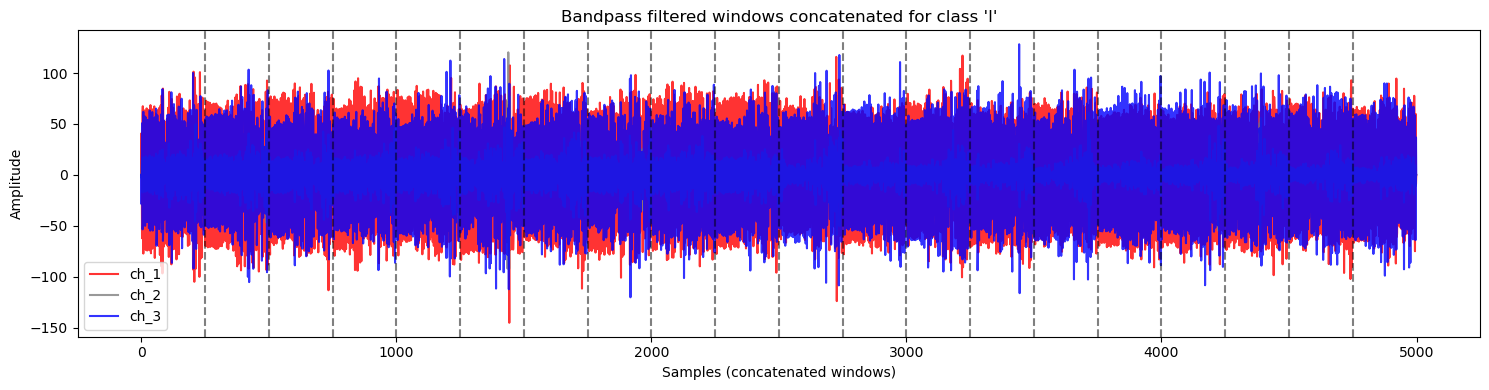

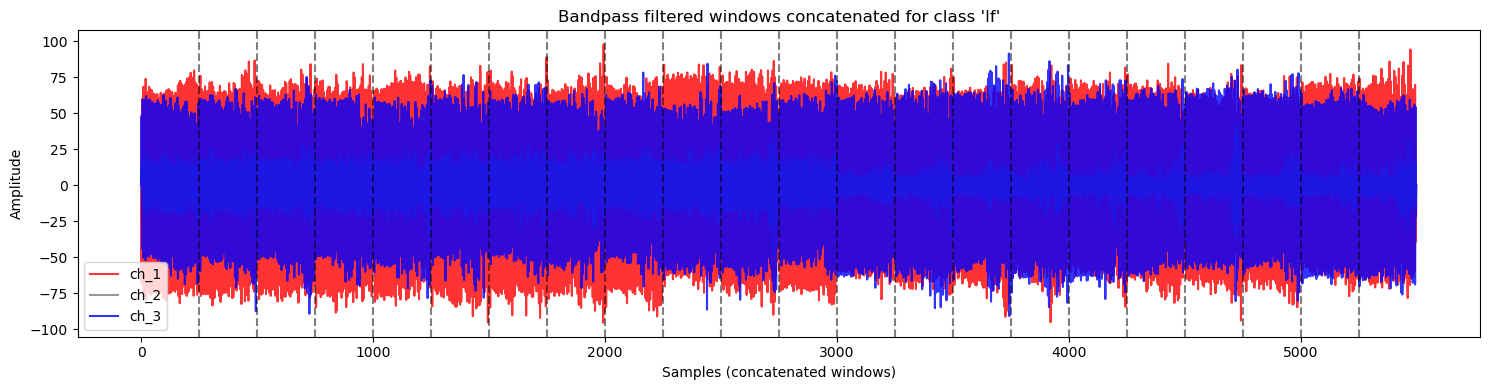

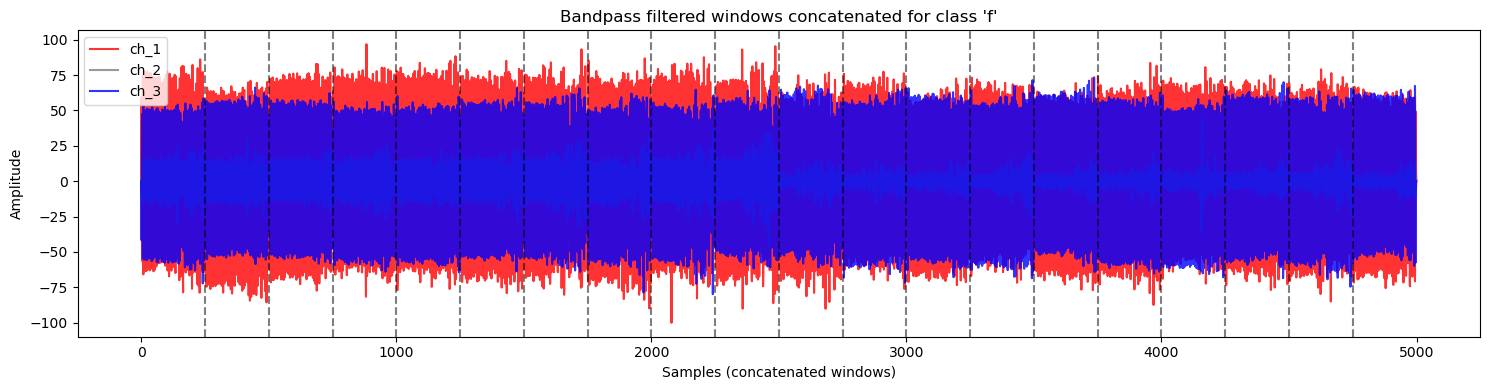

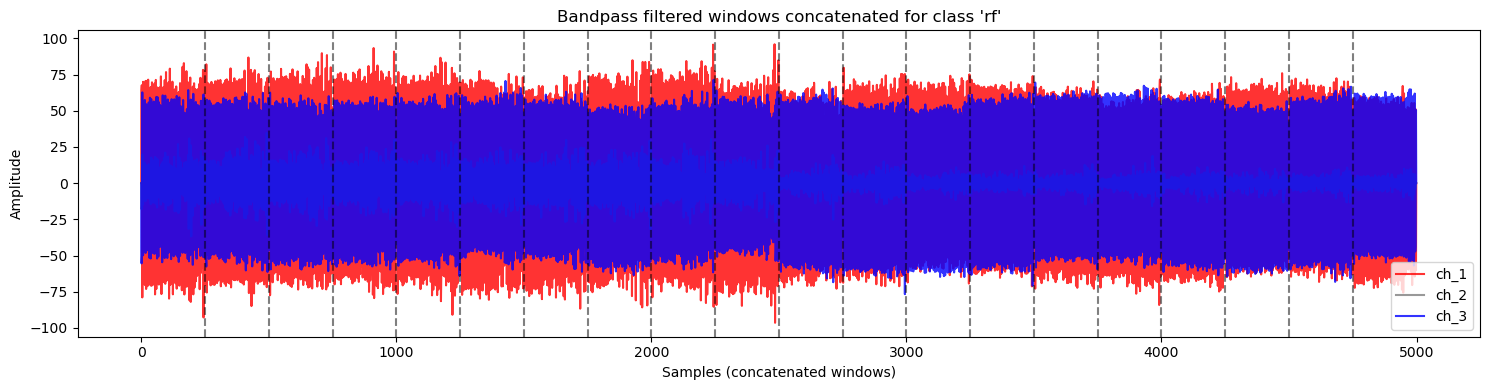

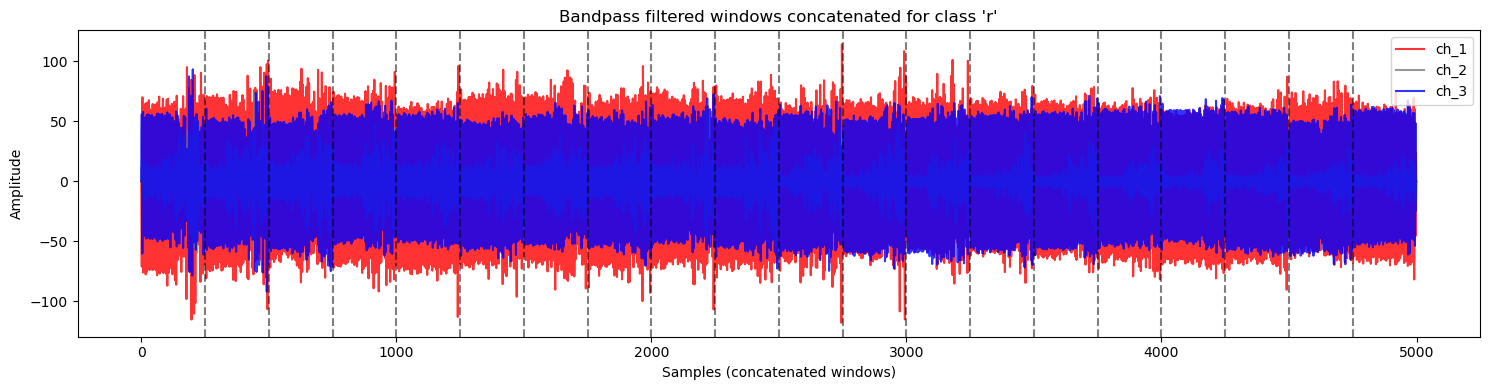

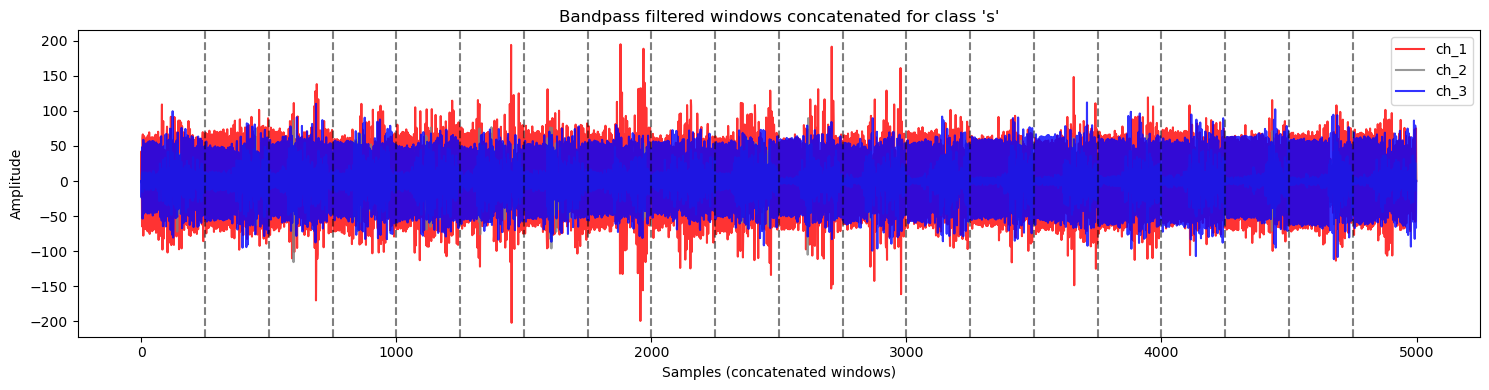

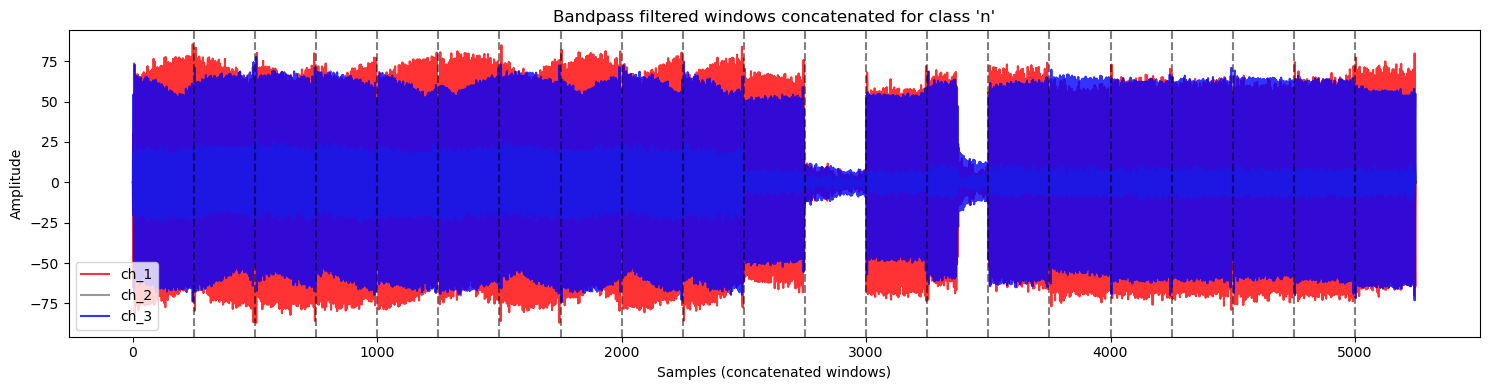

In [41]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

for class_label, windows in filtered.items():
    if not windows:
        continue
    
    concatenated = np.vstack(windows)
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    
    plt.figure(figsize=(15, 4))
    
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Bandpass filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Feature extraction

In [20]:
import numpy as np
import pandas as pd

# -------------- Feature functions 
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def zero_crossings(signal):
    signs = np.sign(signal)
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i-1] if signs[i-1] != 0 else 1
    return np.sum(np.diff(signs) != 0)

def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def mav(signal):
    return np.mean(np.abs(signal))

def iav(signal):
    return np.sum(np.abs(signal))

# -------------------

class_labels = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
channels = ['ch_1', 'ch_2', 'ch_3']
feature_names = ['RMS', 'ZC', 'WL', 'MAV', 'STD', 'VAR', 'IAV']

def extract_features(filtered_data):
    features = []
    labels = []

    for label in class_labels:
        for window in filtered_data.get(label, []):
            feats = []
            for ch_idx in range(len(channels)):
                ch_signal = window[:, ch_idx]
                feats.append(rms(ch_signal))
                feats.append(zero_crossings(ch_signal))
                feats.append(waveform_length(ch_signal))
                feats.append(mav(ch_signal))
                feats.append(np.std(ch_signal))
                feats.append(np.var(ch_signal))
                feats.append(iav(ch_signal))
            features.append(feats)
            labels.append(label)

    cols = []
    for ch in channels:
        for feat_name in feature_names:
            cols.append(f"{ch}_{feat_name}")

    X = pd.DataFrame(features, columns=cols)
    y = pd.Series(labels, name='label')
    return X, y

# Extract features for train and test
X, y = extract_features(filtered)
Xt, yt = extract_features(filtered_test)

print(X.head())
print(y.head())
print(Xt.head())
print(yt.head())


      ch_1_RMS  ch_1_ZC       ch_1_WL     ch_1_MAV   ch_1_STD     ch_1_VAR  \
0  1938.438549        0  13896.370095  1936.708294  81.884018  6704.992483   
1  1921.028327        0  14267.118497  1920.187225  56.840587  3230.852349   
2  1916.445054        0  14173.509383  1915.528764  59.255361  3511.197754   
3  1872.521536        0  13982.692546  1871.743753  53.965027  2912.224111   
4  1907.141735        0  14036.917867  1906.376172  54.032285  2919.487772   

        ch_1_IAV   ch_2_RMS  ch_2_ZC      ch_2_WL  ...   ch_2_STD  \
0  484177.073441  68.375038        9  4020.967073  ...  66.768550   
1  480046.806337  32.149419       43  3886.409560  ...  31.289236   
2  478882.191055  56.206133        9  3726.080514  ...  52.341010   
3  467935.938300  37.245482        9  3681.667587  ...  37.173634   
4  476594.042970  30.178625       43  4033.484052  ...  29.964071   

      ch_2_VAR      ch_2_IAV     ch_3_RMS  ch_3_ZC       ch_3_WL     ch_3_MAV  \
0  4458.039255  15798.458850  5559.

# Classification

## Random Forest Tree

Random Forest Test Accuracy: 0.977


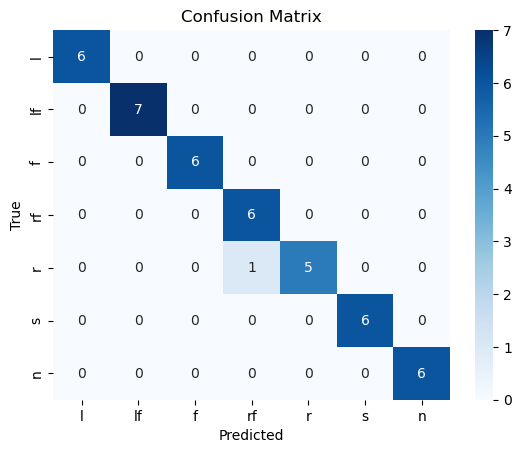

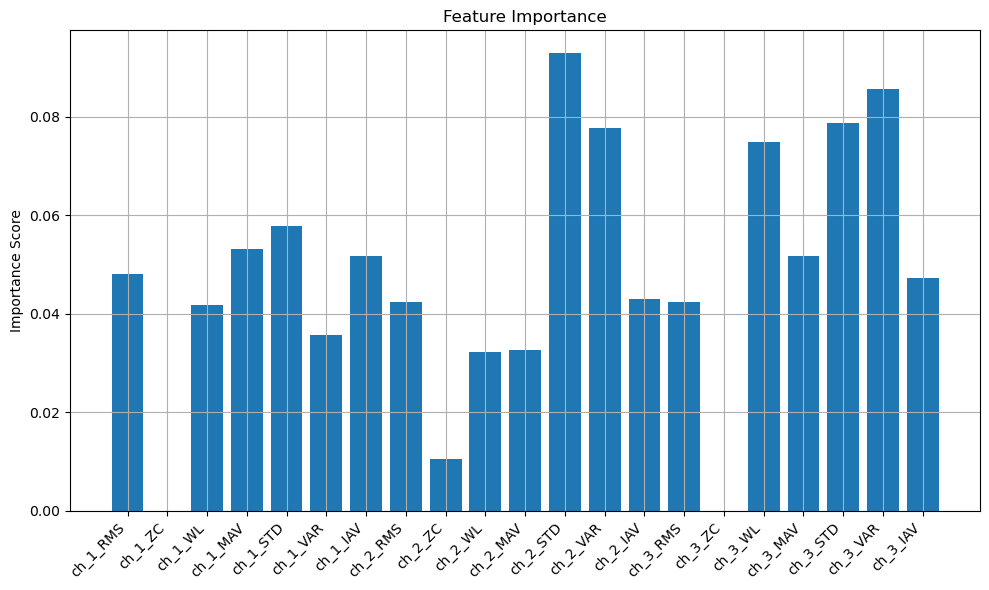

['6_classes_scaler_rf.pkl']

In [22]:
# ------------------------------- RANDOM FOREST TREE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

USE_SCALING = 0

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler_RF = StandardScaler()
X_train_scaled_array = scaler_RF.fit_transform(X_train)
X_test_scaled_array = scaler_RF.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train & 4. Pred
clf_RF = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
if USE_SCALING == 1:
    clf_RF.fit(X_train_scaled, y_train) # with scaling
    y_pred = clf_RF.predict(X_test_scaled)
else:
    clf_RF.fit(X_train, y_train)
    y_pred = clf_RF.predict(X_test)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"Random Forest Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Plot feature importance
importances = clf_RF.feature_importances_
feature_names = X.columns if hasattr(X, 'columns') else [f'feat{i}' for i in range(X.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Save model and scaler
joblib.dump(clf_RF, "6_classes_rf.pkl")
joblib.dump(scaler_RF, "6_classes_scaler_rf.pkl")


## PCA 

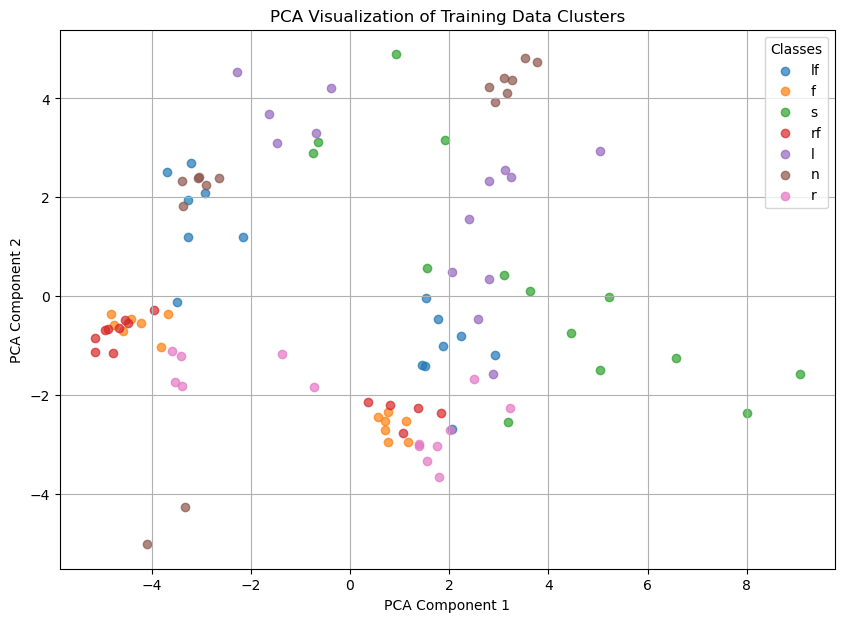

In [45]:
from sklearn.decomposition import PCA

# 2.5 PCA for visualization (2D)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot
plt.figure(figsize=(10, 7))
for label in y_train.unique():
    idx = y_train == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label, alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Training Data Clusters')
plt.legend(title='Classes')
plt.grid(True)
plt.show()


## SVM

SVM Test Accuracy: 0.698


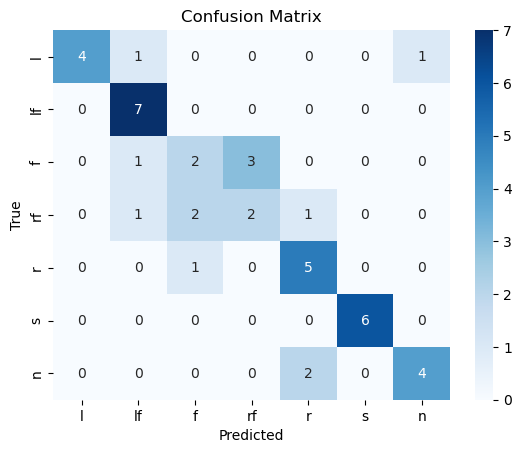

In [50]:
# ----------------------------- SUPPORT VECTOR MACHINE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train 
clf_SVM = SVC(kernel='linear', C=1.0, gamma='scale', class_weight='balanced')
clf_SVM.fit(X_train_scaled, y_train)

# 4. Predict
y_pred = clf_SVM.predict(X_test_scaled)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"SVM Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Save model and scaler
#joblib.dump(clf_SVM, "7_classes_svm.pkl")
#joblib.dump(scaler, "scaler_svm.pkl")


# Test

## Random Forest Tree

Random Forest Test Accuracy: 0.243


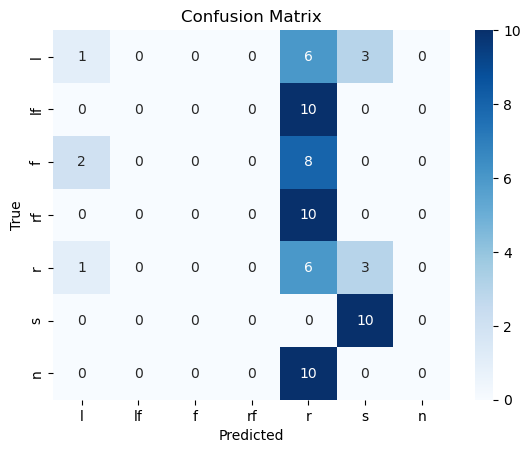

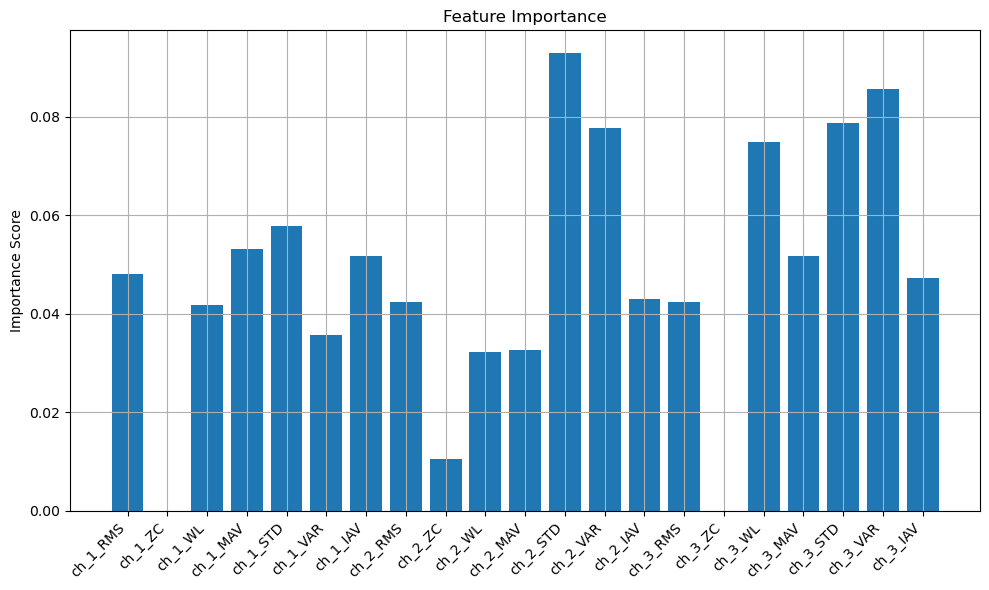

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if USE_SCALING == 1:
    Xt_scaled_array = scaler_RF.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
    y_pred = clf_RF.predict(Xt_scaled)
else:
    y_pred = clf_RF.predict(Xt)
    
# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"Random Forest Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot feature importance
importances = clf_RF.feature_importances_
feature_names = Xt.columns if hasattr(Xt, 'columns') else [f'feat{i}' for i in range(Xt.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()
